# Detecting electrode inversion in an ECG


The ECG is a time series that measures the electrical activity of the heart. This is the main tool to diagnose heart diseases. Recording an ECG is simple: 3 electrodes are placed at the ends of limbs, and 6 on the anterior chest.This generates **12 time series**, called leads, each corresponding to a difference in potential between a pair of electrodes.

The electrodes' position is very important to correctly interpret the ECG. Making the mistake of inverting electrodes compromises interpretation, either because the leads do not explore the expected area (errors in the measures of hypertrophia indices, in the analysis of the ST segment), or because they generate false abnormalities (fake Q waves, error in the heart's axis...).

Inversion errors are frequent (5% of ECGs), and only experts (cardiologists) manage to detect them. But most ECGs are not interpreted by experts: only 30% are, the rest being interpreted by nurses or general practitioners. An algorithm for automatic detection of electrode inversion is therefore paramount to the correct interpretation of ECGs  and would improve the quality of diagnosis.

This project is intended to make you detect electrode inversion in an ECG. The dataset at your disposal contains ECGs from a cardiology center. **An ECG will be labeled as correctly realised (0) or as inverted (1).**
The goal is to perform **binary classification** on these ECGs.

## Inversions

Electrode inversions **do not** necessarily correspond to the inversion of only 2 leads:
* Precordial leads from (V1, ..., V6) can indeed be inverted: V1 becomes V6, V2 becomes V5...
* But when certain pairs of electrodes are exchanged, several leads from I, II, III, AVF, AVR, AVL can be modified differently. For instance, if electrodes of the right and left arms are inverted, then I becomes -I, II and III are inverted, AVL and AVR are inverted and AVF remains the same. Read here for more details on the relationships between the different leads and how they can be affected by inversion: https://litfl.com/ecg-limb-lead-reversal-ecg-library/

## Data

Data is available at the following link:
https://drive.google.com/file/d/1tdjqbkRNqxfDdNbb6pXiX8DvCaFlMOjd/view?usp=sharing

In the archive, you will find:
* input_training.npy
* output_training.npy
* input_test.npy

The training data contains 1400 ECGs and their labels. For each ECG, the data consists of **10 seconds** of recording for **12 leads**, each sampled at **250Hz**. The channels of the samples are in the following order: I, II, III, AVF, AVL, AVR, V1, V2, V3, V4, V5, V5, V6

The testing data contains 2630 ECGs on which you will give your predictions at the end of the homework in a numpy array with a shape (2630,).

Each input file therefore contains the ECG signal in the form **(n_ecgs, n_leads=12, n_samples=2500)**.

## Code

You are free to choose the libraries you use for your implementations.
Use of Keras is preferred for conciseness, but you can use a different DL library if you are unfamiliar with Keras. This will not affect evaluation of the notebook.

## Evaluation

We will use **accuracy** as a metric to evaluate your predictions on the test set.


## Objective

The key objective of this homework is to propose a **deep learning model** relevant to the task that shows good accuracy in detection of lead inversion. A strong notebook should be readable, reproducible and the code must be clean.

Please send back:
- a Jupyter Notebook explaining your process and commenting your results,
- a npy file containing the predictions on the test set

# 1. Load and analyze the data


##Mount and Download Files

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/Colab Notebooks/Assignment_Philips

/gdrive/My Drive/Colab Notebooks/Assignment_Philips


In [4]:
!gdown 1tdjqbkRNqxfDdNbb6pXiX8DvCaFlMOjd

Downloading...
From: https://drive.google.com/uc?id=1tdjqbkRNqxfDdNbb6pXiX8DvCaFlMOjd
To: /gdrive/My Drive/Colab Notebooks/Assignment_Philips/candidate_files_v1.zip
100% 478M/478M [00:07<00:00, 61.0MB/s]


In [8]:
import shutil
shutil.move("/content/candidate_files_v1.zip", "/gdrive/My Drive/Colab Notebooks/Assignment_Philips")

'/gdrive/My Drive/Colab Notebooks/Assignment_Philips/candidate_files_v1.zip'

In [15]:
!unzip '/gdrive/My Drive/Colab Notebooks/Assignment_Philips/candidate_files_v1.zip'

Archive:  /gdrive/My Drive/Colab Notebooks/Assignment_Philips/candidate_files_v1.zip
   creating: candidate_files/
  inflating: candidate_files/input_test_set.npy  
  inflating: candidate_files/input_training.npy  
  inflating: candidate_files/output_training.npy  


##Imports

In [4]:
pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.6 MB/s eta 0:00:00


In [5]:
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
import warnings
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.callbacks import *
import keras.backend as K
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import class_weight
import keras_tuner as kt

tfk = tf.keras
tfkl = tf.keras.layers

In [6]:
# Fixed random seed to make results as reproducible as possible
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Data Loading - Preprocessing

Loading dataset from local folder

In [7]:
X_train = np.load('./candidate_files/input_training.npy')
Y_train = np.load('./candidate_files/output_training.npy')
X_test_final = np.load('./candidate_files/input_test_set.npy')

In [8]:
X_train.shape, Y_train.shape, X_test_final.shape

((1400, 12, 2500), (1400,), (2630, 12, 2500))

Reshaping the arrays in order to have the 12 features as the last dimension, while the number of timestamps (2500 = 250 Hz * 10 sec) as the second dimension, according to the standard (num_data_points, time_stamps, features).

In [9]:
X_train = np.transpose(X_train, (0, 2, 1))
X_test_final = np.transpose(X_test_final, (0, 2, 1))

In [10]:
X_train.shape, Y_train.shape, X_test_final.shape

((1400, 2500, 12), (1400,), (2630, 2500, 12))

Splitting the original Train dataset into Train set and Test set. Test set size = 0.2 of the original Train set. The new Train set will be used for train and validate the model, while the Test set will be used only at the end to evaluate it (see confusion matrix).

In [11]:
X_train_test, X_test, Y_train_test, Y_test = train_test_split(X_train, Y_train, test_size = 0.2, random_state = seed, stratify = Y_train)
X_train_test.shape, X_test.shape, Y_train_test.shape, Y_test.shape

((1120, 2500, 12), (280, 2500, 12), (1120,), (280,))

Scaling the values using RobustScaler (final results slightly better w.r.t raw dataset) (Used also MinMaxScaler and StandardScaler but with lower results)

In [12]:
scaler = RobustScaler()

def scaling_values(dataset, scaler, is_train=True):
  num_instances, num_time_steps, num_features = dataset.shape
  dataset_reshaped = np.reshape(dataset, newshape=(-1, num_features))
  if(is_train):
    dataset_reshaped = scaler.fit_transform(dataset_reshaped)
  else:
    dataset_reshaped = scaler.transform(dataset_reshaped)
  dataset_reshaped = np.reshape(dataset_reshaped, newshape=(num_instances, num_time_steps, num_features))
  return dataset_reshaped

In [13]:
X_train_test = scaling_values(X_train_test, scaler, is_train=True)
print(X_train_test.shape)

(1120, 2500, 12)


Converting Y_train to binary class matrix (ONLY in case of using Categorical Crossentropy, otherwise skip this cell)

In [14]:
Y_train_test = tfk.utils.to_categorical(Y_train_test)
print(Y_train_test.shape)

(1120, 2)


Displaying the Time-Series for each single feature

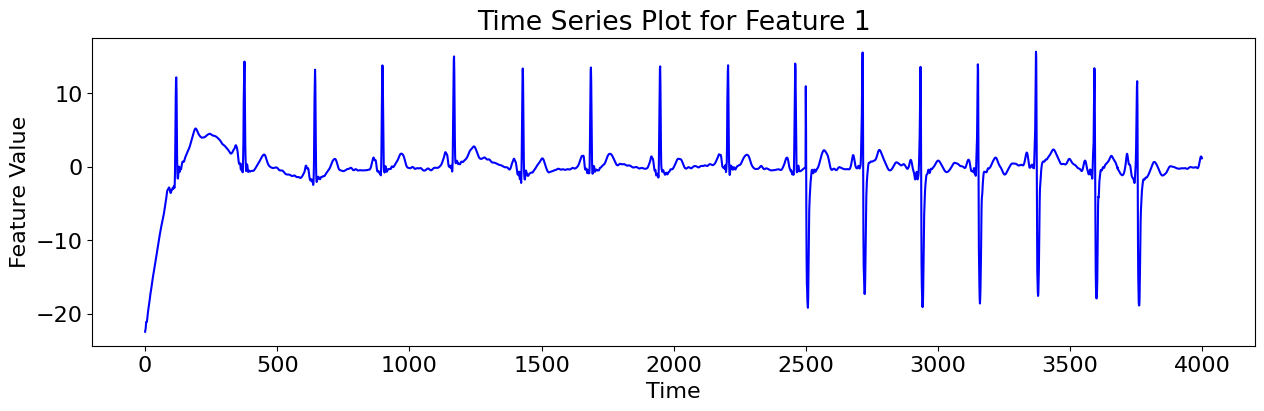

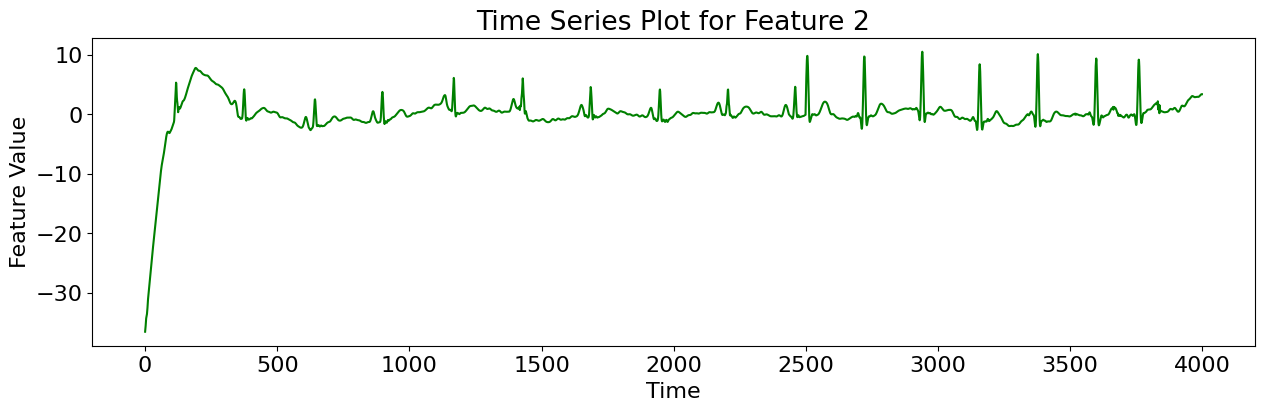

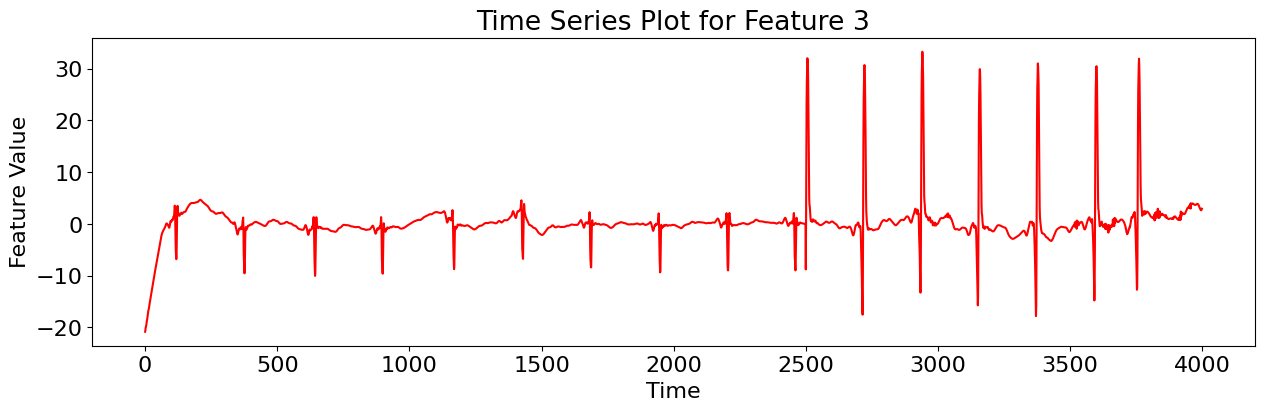

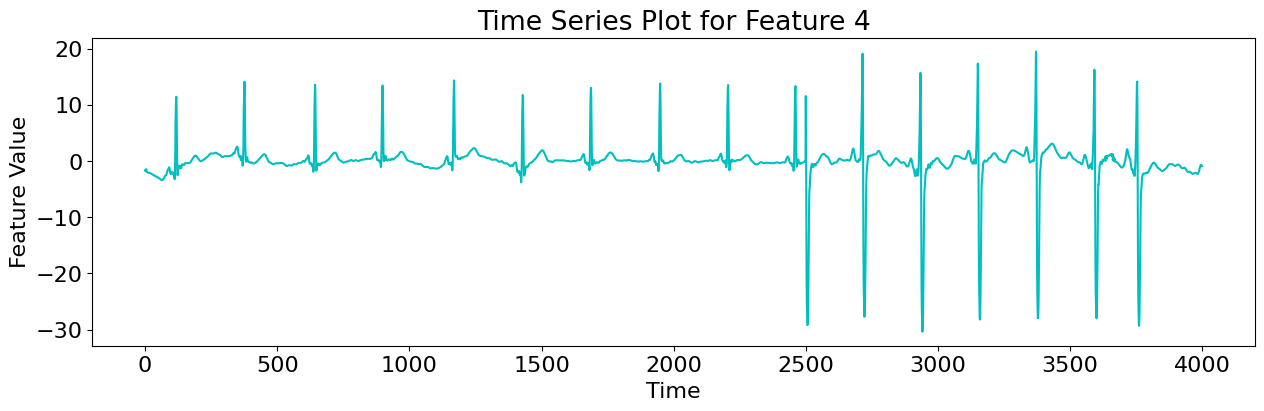

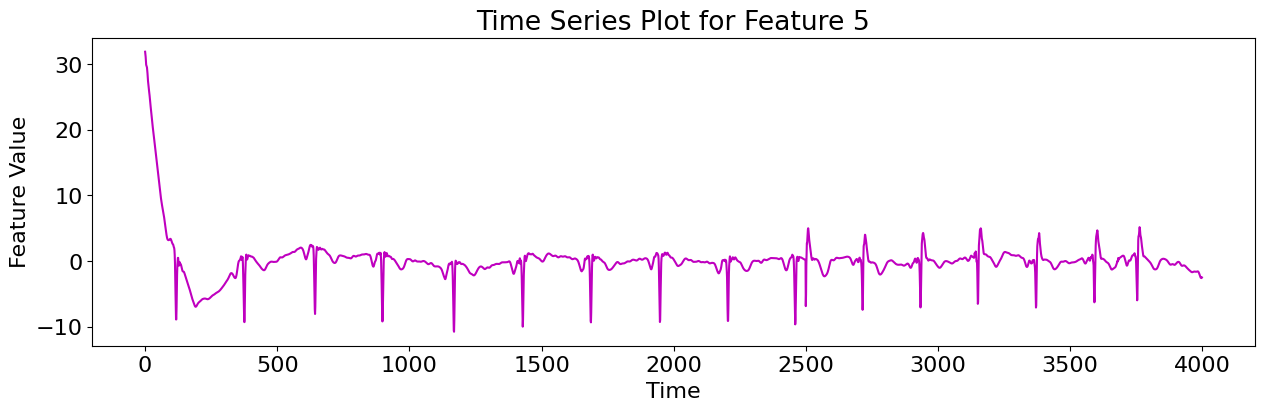

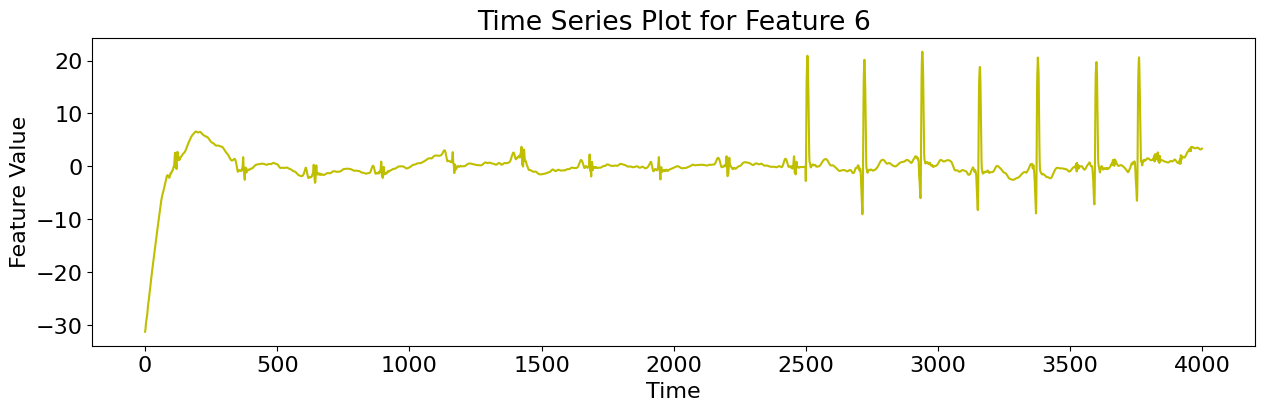

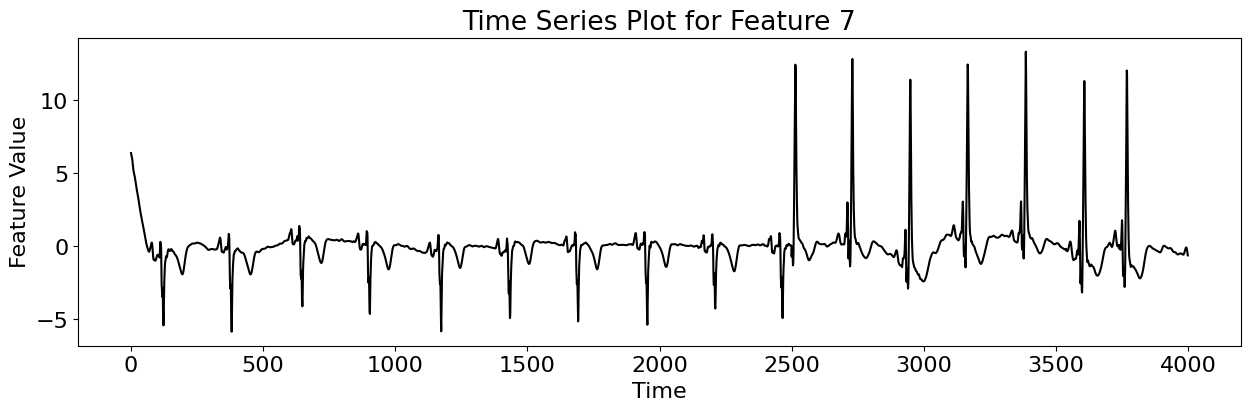

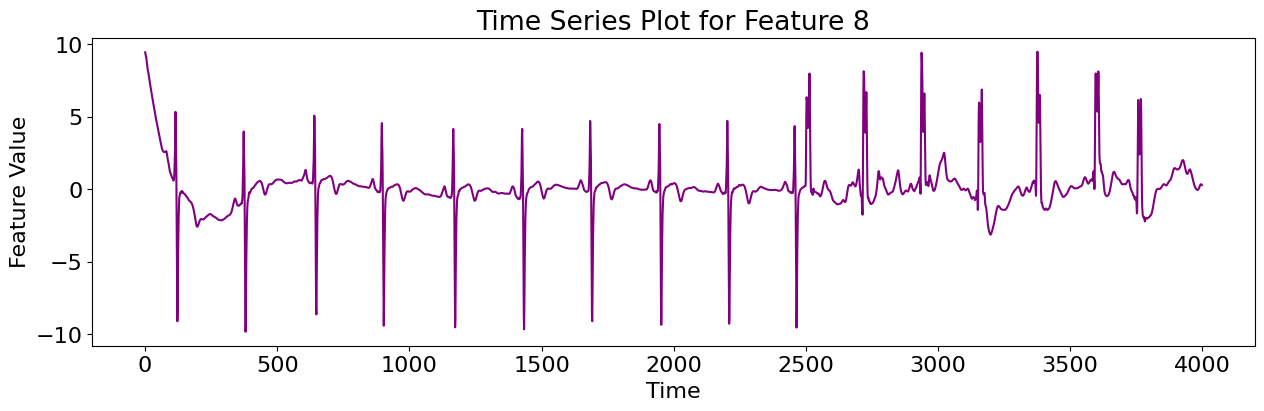

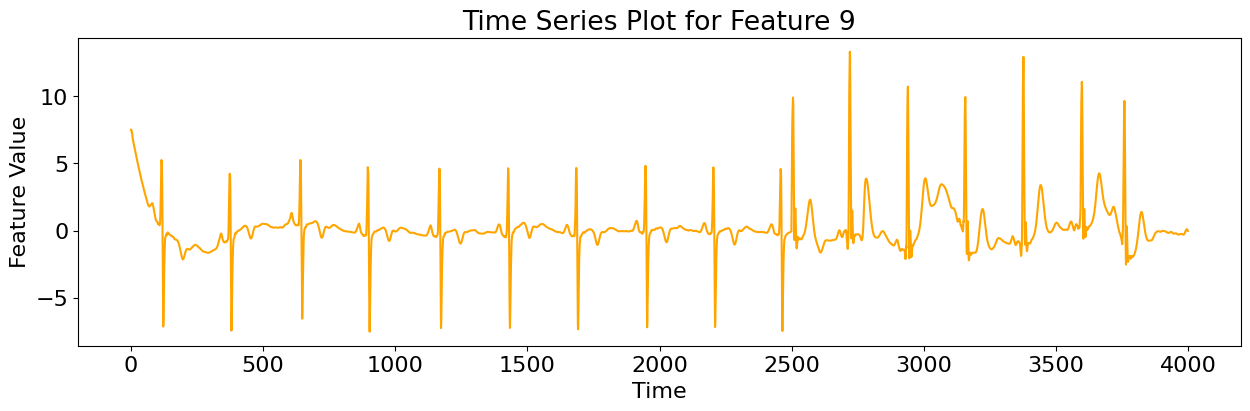

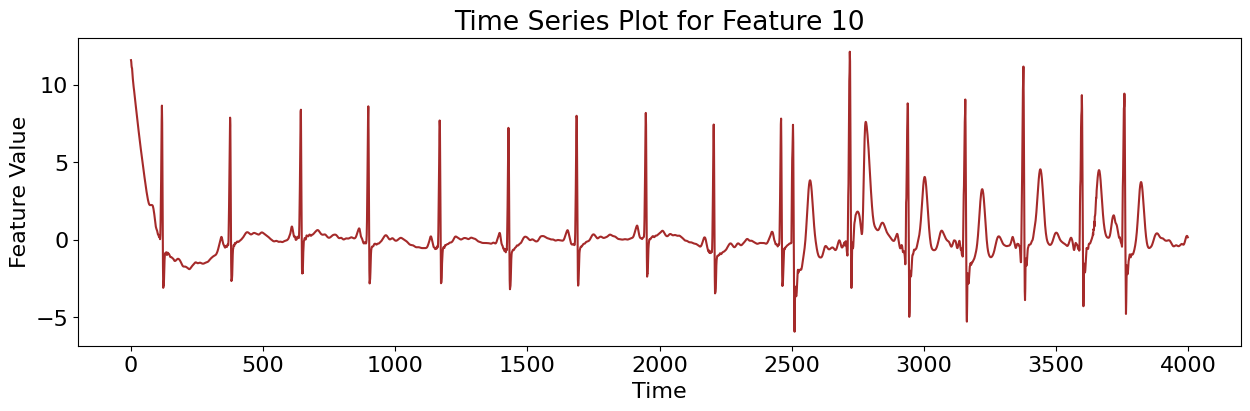

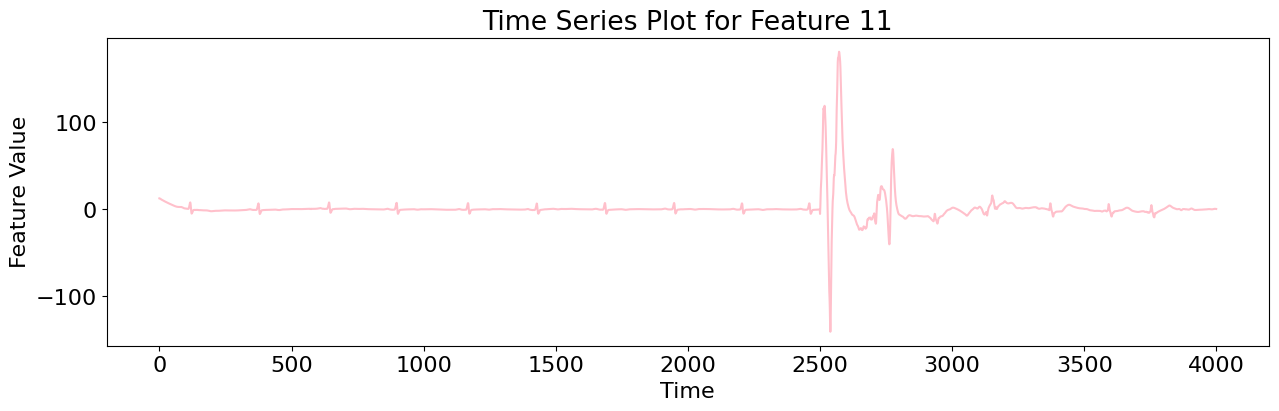

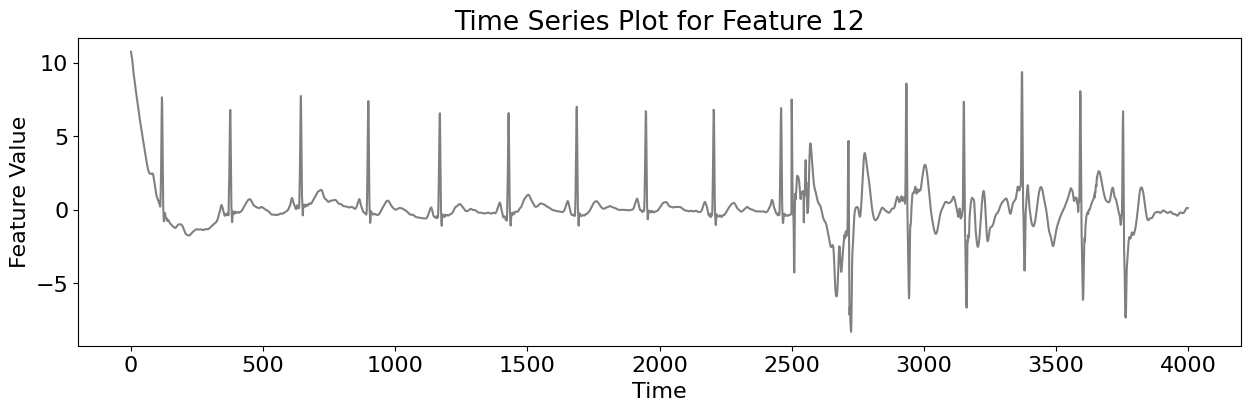

In [18]:
features_to_plot = [i for i in range(X_train_test.shape[2])]  #Choose feature indices
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange', 'brown', 'pink', 'gray']
# Plot time series for selected features
for i, feature_idx in enumerate(features_to_plot):
    plt.figure(figsize=(15,4))
    plt.plot(X_train_test[:, :, feature_idx].flatten()[:4000], label=f'Feature {feature_idx + 1}', color=colors[i])
    plt.xlabel('Time')
    plt.ylabel('Feature Value')
    plt.title(f'Time Series Plot for Feature {feature_idx + 1}')
    plt.show()

Converting the train labels to a DataFrame

In [15]:
df_y_train = pd.DataFrame(Y_train_test, columns=['Category_1', 'Category_2'])
print(df_y_train)

      Category_1  Category_2
0            1.0         0.0
1            0.0         1.0
2            0.0         1.0
3            0.0         1.0
4            1.0         0.0
...          ...         ...
1115         0.0         1.0
1116         1.0         0.0
1117         1.0         0.0
1118         0.0         1.0
1119         0.0         1.0

[1120 rows x 2 columns]


Computing the histogram to check the balance of the dataset

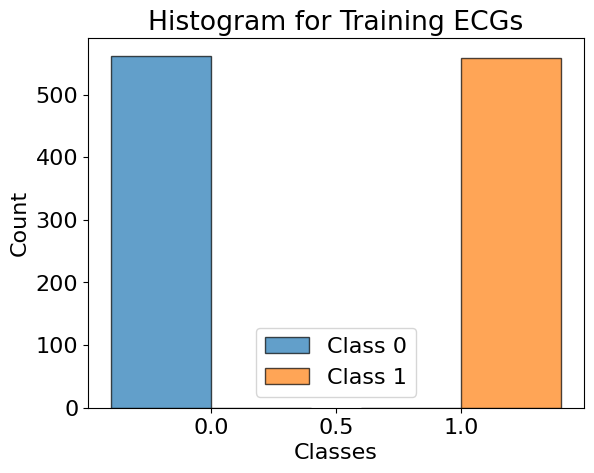

In [16]:
labels = np.argmax(Y_train_test, axis=1)

# Plot histogram
plt.hist([labels[labels==0], labels[labels==1]], bins=np.arange(labels.min(), labels.max() + 2) - 0.5, edgecolor='black', width=0.4, align='mid', label=['Class 0', 'Class 1'], alpha=0.7)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Histogram for Training ECGs')
plt.legend()
plt.show()

Preparing the input and classes shapes for the model

In [17]:
input_shape = X_train_test.shape[1:]
classes = Y_train_test.shape[-1]

print('Input Shape: ', input_shape)
print('Y_train Shape: ', Y_train_test.shape)
print('Number of Classes: ', classes)

Input Shape:  (2500, 12)
Y_train Shape:  (1120, 2)
Number of Classes:  2


# 2.Classification using the raw signal
The goal here is to perform classification using directly the raw data.


### a) Which variant of neural networks would be more adequate for the task? (RNN, CNN, DNN...)

A common approach to analyze time-series is by exploiting RNNs (like the variants of LSTM, BiLSTM, GRU ecc.) which are extremely useful in the case in which the are relations and temporal dependencies in the sequential data that need to be captured. In our case, to classify an inversion we are interested in looking at the peak of the time-series, which is a local feature without a distance relationship during time (differently for example from time-series prediction or text generation). Here it is more useful to see the structure of the peak, and that's why a Conv Network is more suited, in order to identify patterns and local dependencies in a hierarchical way.

### b) Train and evaluate a classifier using the raw signal
Train and evaluate the method of your choice using only the signal from the training set.

We expect:
- a simple architecture relevant for the task
- a model converging without overfitting
- high performances on the testing set

Note: It is not complicated to reach an accuracy of 85% on the testing set

### c) What would you explore to improve your results?

A way to firstly improve the result can be to augment the dataset. This could be done by exploiting existing libraries like tsgm or tsaug. We must pay particular attention to the fact that not all the types of techniques can be useful in our case and can give improvements. Since we want to capture the feature of inverted peaks for example it is important not to perform an augmentation that invert them because this can lead to a wrong initial label categorization (something that can be useful could be a gaussian noise). Another way could be to perform a fine-tuning of a pre-existing model (already feeded with a large amount of ECGs) that already has the base knowledge of ECGs and that could be specialized to this specific task.

## First Approach - Simple 1D CNN Network

In [25]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [40]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2500, 12)]        0         
                                                                 
 conv1d (Conv1D)             (None, 2500, 128)         4736      
                                                                 
 max_pooling1d (MaxPooling1  (None, 1250, 128)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1250, 128)         49280     
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout (Dropout)           (None, 128)               0     

In [ ]:
history = model.fit(
    x = X_train_test,
    y = Y_train_test,
    batch_size = 8,
    epochs = 200,
    validation_split = 0.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Since the results with this model were pretty encouraging, I decided to tune some parameters (n_filter, n_kernels, dropout_rate, learning_rate, batch_size, optimizer type) and try to add few more Conv1D and MaxPooling1D layers with the use of KerasTuner

In [19]:
def build_1DCNN_classifier(hp):
      input_layer = tfkl.Input(shape=(2500, 12), name='Input')

      #parameters to be optimized
      hp_units = hp.Choice('filters', values=[64, 128, 256, 512, 1024])
      hp_kernels = hp.Choice('kernel_size', values=[3, 5, 7])
      drop_out_rates = hp.Choice('rate', values=[0.2, 0.3, 0.4, 0.5])
      learning_rates = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
      hp_batch_size = hp.Choice('batch_size',  values=[8, 16, 32, 64])
      num_block = hp.Int('num_block', min_value=0, max_value=2, step=1)
      optimizer_type = hp.Choice('optimizer', values=['adam', 'adamw'])

      # Feature extractor
      cnn = tfkl.Conv1D(filters=hp_units , kernel_size=hp_kernels, padding='same', activation='relu')(input_layer)

      for i in range(num_block):
        cnn = tfkl.MaxPooling1D()(cnn)

      for i in range(num_block):
        cnn = tfkl.Conv1D(filters=hp_units , kernel_size=hp_kernels,padding='same',activation='relu')(cnn)

      for i in range(num_block):
        cnn = tfkl.MaxPooling1D()(cnn)

      cnn = tfkl.Conv1D(filters=hp_units , kernel_size=hp_kernels,padding='same',activation='relu')(cnn)
      gap = tfkl.GlobalAveragePooling1D()(cnn)
      dropout = tfkl.Dropout(rate = drop_out_rates, seed=seed)(gap)

      # Classifier
      classifier = tfkl.Dense(units=hp_units, activation='relu')(dropout)
      output_layer = tfkl.Dense(2, activation='softmax')(classifier)

      # Connect input and output through the Model class
      model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

      if optimizer_type == 'adam':
        optimizer = tfk.optimizers.Adam(learning_rate=learning_rates)
      elif optimizer_type == 'adamw':
        optimizer = tfk.optimizers.AdamW(learning_rate=learning_rates)

      # Compile the model
      model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics='accuracy')

      # Return the model
      return model

Searching the best combination of parameters

In [24]:
tuner1 = kt.Hyperband(build_1DCNN_classifier,
                     objective='val_accuracy',
                     max_epochs=150,
                     factor=3)
callbacks = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
tuner1.search(X_train_test, Y_train_test, epochs=150, validation_split=0.1, callbacks=[callbacks], verbose=1)

Building the best model

In [22]:
best_hps = tuner1.get_best_hyperparameters()[0]
model = tuner1.hypermodel.build(best_hps)
model.summary()
model.save('Best_Model_1DCNN')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2500, 12)]        0         
                                                                 
 conv1d (Conv1D)             (None, 2500, 64)          5440      
                                                                 
 max_pooling1d (MaxPooling1  (None, 1250, 64)          0         
 D)                                                              
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 625, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_1 (Conv1D)           (None, 625, 64)           28736     
                                                                 
 conv1d_2 (Conv1D)           (None, 625, 64)           28736 

Training the best model

In [23]:
history = model.fit(
    x = X_train_test,
    y = Y_train_test,
    batch_size = tuner1.hyperparameters.values['batch_size'], #tried 8, 16, 32 (best), 64
    epochs = 200,
    validation_split = 0.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
35/35 [==============================] - 14s 32ms/step - loss: 0.7066 - accuracy: 0.5821 - val_loss: 0.6036 - val_accuracy: 0.7357 - lr: 0.0010
Epoch 2/200
35/35 [==============================] - 0s 14ms/step - loss: 0.5523 - accuracy: 0.7598 - val_loss: 0.3979 - val_accuracy: 0.8393 - lr: 0.0010
Epoch 3/200
35/35 [==============================] - 1s 16ms/step - loss: 0.3799 - accuracy: 0.8473 - val_loss: 0.3516 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 4/200
35/35 [==============================] - 0s 13ms/step - loss: 0.3188 - accuracy: 0.8679 - val_loss: 0.2548 - val_accuracy: 0.8893 - lr: 0.0010
Epoch 5/200
35/35 [==============================] - 0s 13ms/step - loss: 0.3215 - accuracy: 0.8643 - val_loss: 0.2752 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 6/200
35/35 [==============================] - 0s 14ms/step - loss: 0.2579 - accuracy: 0.8830 - val_loss: 0.2117 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 7/200
35/35 [==============================] - 0s 14ms/step - l

Plotting the results of accuracy and categorical cross-entropy

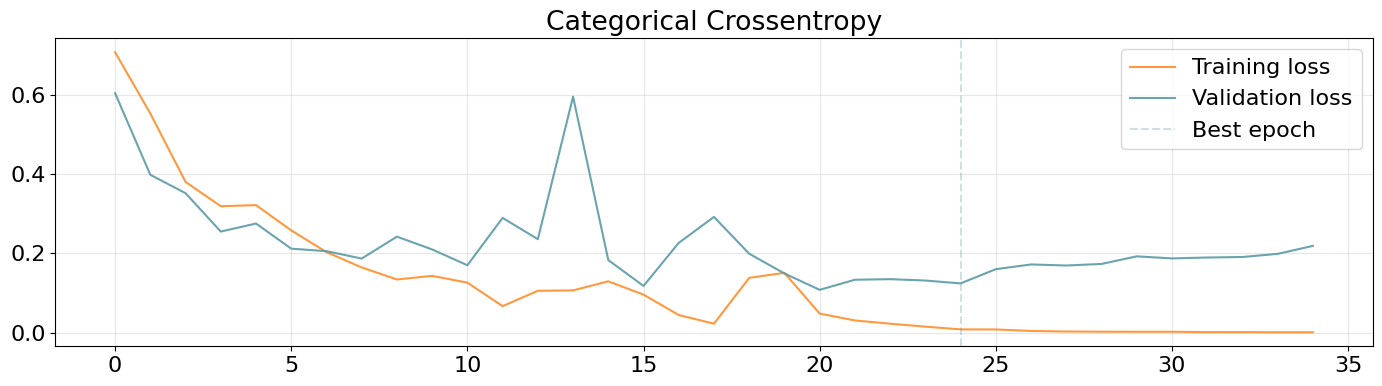

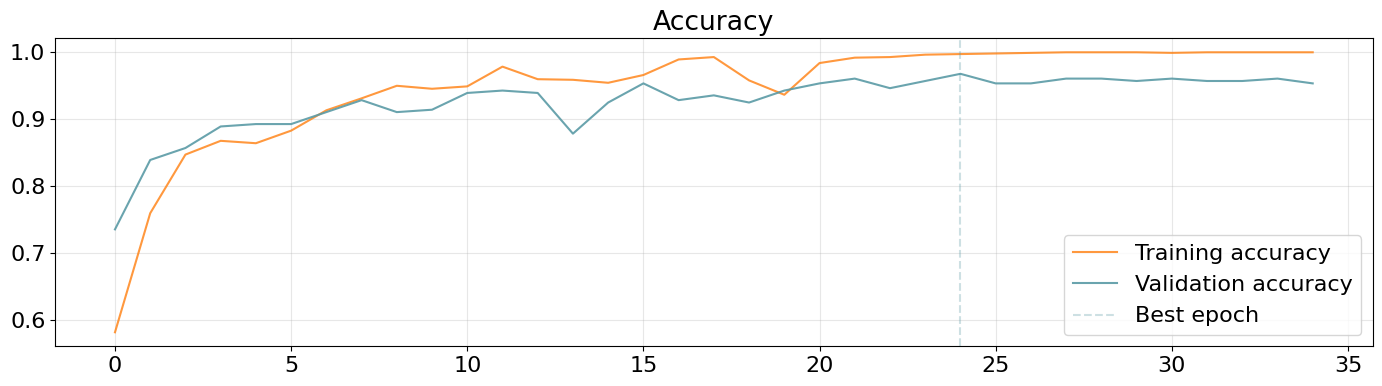

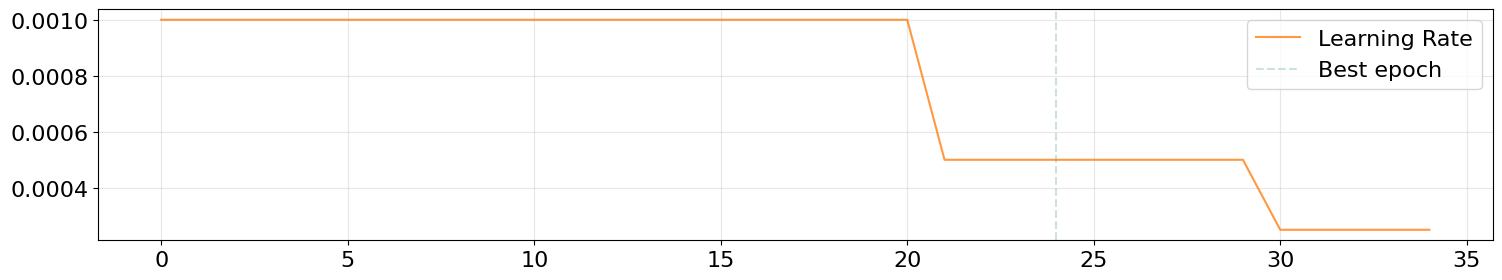

In [27]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## Using K-Fold Cross-Val

Loading the saved optimal model

In [12]:
model = tf.keras.models.load_model('./Best_Model_1DCNN')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2500, 12)]        0         
                                                                 
 conv1d (Conv1D)             (None, 2500, 64)          5440      
                                                                 
 max_pooling1d (MaxPooling1  (None, 1250, 64)          0         
 D)                                                              
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 625, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_1 (Conv1D)           (None, 625, 64)           28736     
                                                                 
 conv1d_2 (Conv1D)           (None, 625, 64)           28736 

Reimplementing the structure of the optimal model (if needed)

In [23]:
def build_1DCNN_classifier(input_shape, classes):
      # Build the neural network layer by layer
      input_layer = tfkl.Input(shape=input_shape, name='Input')

      # Feature extractor
      cnn = tfkl.Conv1D(filters=64 , kernel_size=7, padding='same', activation='relu')(input_layer)

      cnn = tfkl.MaxPooling1D()(cnn)
      cnn = tfkl.MaxPooling1D()(cnn)

      cnn = tfkl.Conv1D(filters=64 , kernel_size=7,padding='same',activation='relu')(cnn)
      cnn = tfkl.Conv1D(filters=64 , kernel_size=7,padding='same',activation='relu')(cnn)

      cnn = tfkl.MaxPooling1D()(cnn)
      cnn = tfkl.MaxPooling1D()(cnn)

      cnn = tfkl.Conv1D(filters=64 , kernel_size=7,padding='same',activation='relu')(cnn)
      gap = tfkl.GlobalAveragePooling1D()(cnn)
      dropout = tfkl.Dropout(rate = 0.4, seed=seed)(gap)

      # Classifier
      classifier = tfkl.Dense(units=64, activation='relu')(dropout)
      output_layer = tfkl.Dense(1, activation='sigmoid')(classifier) #################### 2 Classes & softmax for CategoricalCrossentropy while 1 Class for BinaryCrossEntropy & sigmoid

      # Connect input and output through the Model class
      model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

      # Compile the model
      model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate=0.001), metrics='accuracy')

      # Return the model
      return model

K-Fold Cross-validation

In [17]:
# Define the number of folds for cross-validation
num_folds = 10

# Initialize lists to store training histories, scores, and best epochs
histories = []
scores = []
best_epochs = []

# Create a KFold cross-validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
scaler = RobustScaler()


# Loop through each fold
for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(X_train_test, Y_train_test)):

  print("\n----------------- Starting training on fold num: {} -----------------\n".format(fold_idx+1))

  #Separating Train e Val set
  X_train_temp = X_train_test[train_idx]
  Y_train_temp = Y_train_test[train_idx]
  X_val_temp = X_train_test[valid_idx]
  Y_val_temp = Y_train_test[valid_idx]

  #Catergorize the Y values - ONLY IF USE CATEGORICAL CROSS ENTROPY
  # Y_train_temp = tfk.utils.to_categorical(Y_train_temp)
  # Y_val_temp = tfk.utils.to_categorical(Y_val_temp)

  print('X_train_temp shape: ', X_train_temp.shape)
  print('X_val_temp shape: ', X_val_temp.shape)
  print('Y_train_temp shape: ', Y_train_temp.shape)
  print('Y_val_temp shape: ', Y_val_temp.shape)

  # Robust Scaling on X_train and X_val data
  X_train_scaled = scaling_values(X_train_temp, scaler, is_train=True)
  X_val_scaled = scaling_values(X_val_temp, scaler, is_train=False)

  input_shape = X_train_scaled.shape[1:]
  classes = Y_train_temp.shape[-1]
  batch_size = 32
  epochs = 200
  print('Input shape: ', input_shape)

  # Build a new dropout model for each fold
  k_model = build_1DCNN_classifier(input_shape, classes)
  # Train the model on the training data for this fold
  history = k_model.fit(
    x = X_train_scaled,
    y = Y_train_temp,
    validation_data=(X_val_scaled, Y_val_temp),
    batch_size = 32,
    epochs = epochs,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ],
    verbose = 1
  ).history

  # Evaluate the model on the validation data for this fold
  score = k_model.evaluate(X_val_scaled, Y_val_temp, verbose=0)
  scores.append(score[1])

  best_epoch = len(history['val_accuracy']) - 10 #10 = value of the patience for early stopping
  print('Best Epoch: ', best_epoch)
  best_epochs.append(best_epoch)
  # Store the training history for this fold
  histories.append(history)


----------------- Starting training on fold num: 1 -----------------

X_train_temp shape:  (1008, 2500, 12)
X_val_temp shape:  (112, 2500, 12)
Y_train_temp shape:  (1008,)
Y_val_temp shape:  (112,)
Input shape:  (2500, 12)
Epoch 1/200
32/32 [==============================] - 3s 23ms/step - loss: 0.6769 - accuracy: 0.5794 - val_loss: 0.5148 - val_accuracy: 0.7946 - lr: 0.0010
Epoch 2/200
32/32 [==============================] - 0s 13ms/step - loss: 0.4719 - accuracy: 0.7917 - val_loss: 0.4340 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 3/200
32/32 [==============================] - 0s 15ms/step - loss: 0.4030 - accuracy: 0.8423 - val_loss: 0.4147 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 4/200
32/32 [==============================] - 0s 15ms/step - loss: 0.3553 - accuracy: 0.8661 - val_loss: 0.3275 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 5/200
32/32 [==============================] - 0s 15ms/step - loss: 0.3334 - accuracy: 0.8542 - val_loss: 0.4068 - val_accuracy: 0.8214 - lr: 0.0010
E

Plotting both Training and Validation Accuracies

Accuracy: 
Mean Accuracy: 0.9634



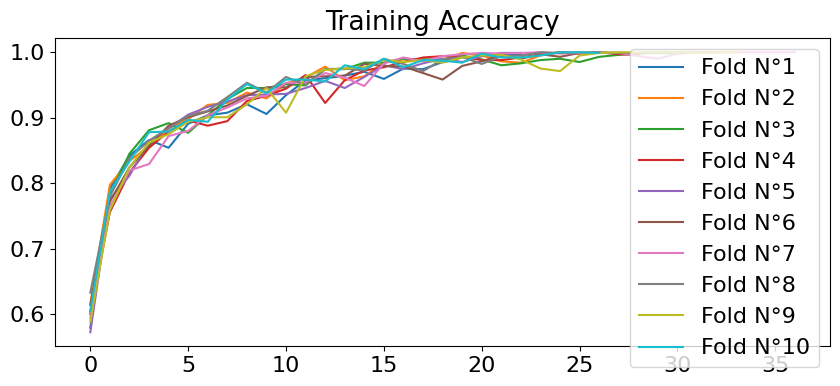

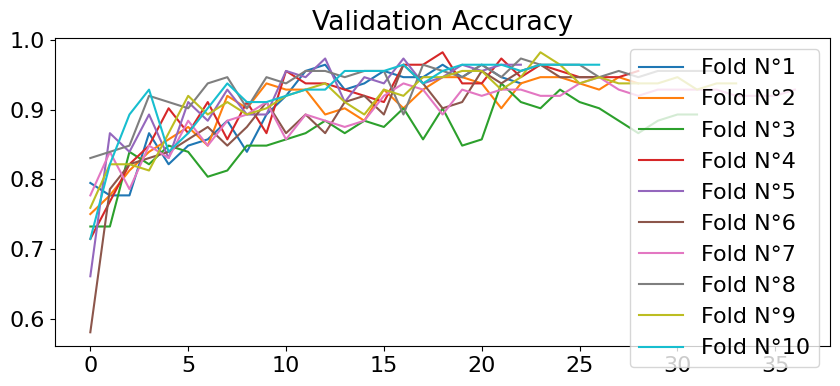

In [18]:
# Define a list of colors for plotting
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Print mean value of accuracy
print(f"Mean Accuracy: {np.mean(scores).round(4)}\n")

# Create a figure for Train Accuracy Visualization
plt.figure(figsize=(10,4))

# Plot Accuracy for each fold
for fold_idx in range(num_folds):
  plt.plot(histories[fold_idx]['accuracy'], color=colors[fold_idx], label=f'Fold N°{fold_idx+1}')
  plt.title('Training Accuracy')
  plt.legend()

# Show the plot
plt.show()


# Create a figure for Validation Accuracy Visualization
plt.figure(figsize=(10,4))

# Plot Accuracy for each fold
for fold_idx in range(num_folds):
  plt.plot(histories[fold_idx]['val_accuracy'], color=colors[fold_idx], label=f'Fold N°{fold_idx+1}')
  plt.title('Validation Accuracy')
  plt.legend()

# Show the plot
plt.show()

Measuring the Average Best Epoch

In [20]:
# Calculate the average best epoch
avg_epochs = int(np.mean(best_epochs))
print(f"Best average epoch: {avg_epochs}")

Best average epoch: 19


Retraining the optimal model on the entire Train data for the Evaluation on the Test data:

Scaling Train Data and Test data

In [21]:
scaler = RobustScaler()

#X_train
X_train_scaled = scaling_values(X_train_test, scaler, is_train=True)
print(X_train_scaled.shape)

#X_test
X_test_scaled = scaling_values(X_test, scaler, is_train=False)
print(X_test_scaled.shape)

(1120, 2500, 12)
(280, 2500, 12)


Converting Y_train to binary class matrix (ONLY in case of using Categorical Crossentropy, otherwise skip this cell)

In [16]:
Y_train_test = tfk.utils.to_categorical(Y_train_test)
Y_test = tfk.utils.to_categorical(Y_test)

print(Y_train_test.shape)
print(Y_test.shape)

(1120, 2)
(280, 2)


Train the final model on the entire Train data

In [76]:
final_model = build_1DCNN_classifier(input_shape, classes)

final_history = final_model.fit(
    x = X_train_test,
    y = Y_train_test,
    batch_size = 32,
    epochs = 100,
    verbose = 1
  ).history

Epoch 1/100
35/35 [==============================] - 2s 14ms/step - loss: 0.6887 - accuracy: 0.5473
Epoch 2/100
35/35 [==============================] - 0s 11ms/step - loss: 0.6038 - accuracy: 0.7339
Epoch 3/100
35/35 [==============================] - 0s 11ms/step - loss: 0.4840 - accuracy: 0.8009
Epoch 4/100
35/35 [==============================] - 0s 11ms/step - loss: 0.4386 - accuracy: 0.8259
Epoch 5/100
35/35 [==============================] - 0s 11ms/step - loss: 0.3896 - accuracy: 0.8438
Epoch 6/100
35/35 [==============================] - 0s 11ms/step - loss: 0.3299 - accuracy: 0.8527
Epoch 7/100
35/35 [==============================] - 0s 13ms/step - loss: 0.3107 - accuracy: 0.8661
Epoch 8/100
35/35 [==============================] - 0s 12ms/step - loss: 0.2528 - accuracy: 0.8973
Epoch 9/100
35/35 [==============================] - 0s 11ms/step - loss: 0.2318 - accuracy: 0.8991
Epoch 10/100
35/35 [==============================] - 0s 11ms/step - loss: 0.2118 - accuracy: 0.9187

Prediction on the Test Set

In [61]:
# Predict the test set
predictions = final_model.predict(X_test)

# #use this for CategoricalCross Entropy
# binary_predictions = (predictions > 0.5).astype(int)

#Use this for BinaryCrossEntropy
binary_predictions = np.round(predictions).tolist()
binary_predictions = np.squeeze(np.array(binary_predictions))

9/9 [==============================] - 0s 8ms/step


Confusion Matrix

Accuracy: 0.9571
Precision: 0.9572
Recall: 0.9571
F1: 0.9571


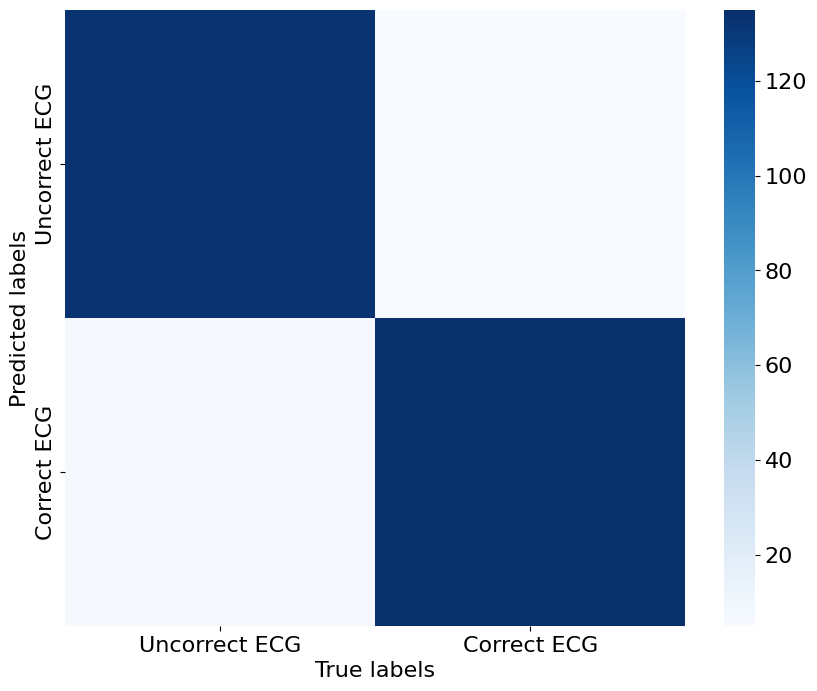

In [63]:
label_mapping = {
    'Uncorrect ECG': 0,
    'Correct ECG': 1,
}
# Compute the confusion matrix

##use this for CategoricalCrossEntropy
# cm = confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(binary_predictions, axis=-1))

#Use this for BinaryCrossEntropy
cm = confusion_matrix(Y_test, binary_predictions)

# Compute the classification metrics

##use this for CategoricalCross Entropy
# accuracy = accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1))
# precision = precision_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
# recall = recall_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
# f1 = f1_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

#Use this for BinaryCrossEntropy
accuracy = accuracy_score(Y_test, binary_predictions)
precision = precision_score(Y_test, binary_predictions, average='macro')
recall = recall_score(Y_test, binary_predictions, average='macro')
f1 = f1_score(Y_test, binary_predictions, average='macro')

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# 3. Prediction on the test set
Use the output model of section 2 to make predictions on the testing set.

**Save your predictions in a file predictions.npy that you will send along with your notebook.**

The expected format is a binary array of shape (n_ecgs=2630,) where each value corresponds to the prediction on the corresponding ECG of the test set.

I repeated this last process (at the end of phase 2.) for training the model on the original Train Dataset (input_training.npy and output_training.npy) in order to then make the prediction on the original Test Dataset (input_test.npy)

In [73]:
# Predict the test set with the 1DCNN
predictions = final_model.predict(X_test_final)

##use this for CategoricalCross Entropy
# binary_predictions = (predictions > 0.5).astype(int)

#Use this for BinaryCrossEntropy
binary_predictions = np.round(predictions).tolist()
binary_predictions = np.squeeze(np.array(binary_predictions))

83/83 [==============================] - 1s 9ms/step


In [75]:
np.save('./final_predictions.npy', binary_predictions)